<a href="https://colab.research.google.com/github/JazmineOrtizMarin/Simulaci-n-2/blob/main/Proyecto_MMC_corregido_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy
import matplotlib.pyplot as plt
import simpy
import sympy as sp
import random
import math
import statistics
from dataclasses import dataclass

In [ ]:
@dataclass
class Escenario:
    # Guarda los parámetros de la simulación
    lam: float  # Tasa de llegadas
    mu: float  # Tasa de servicio
    c: int   # Número de doctores

class Clinica:
    def __init__(self, env, escenario):
        self.env = env
        self.escenario = escenario

        # El recurso clave: Los Doctores
        # simpy.Resource maneja la cola FIFO automáticamente
        self.doctores = simpy.Resource(env, capacity=escenario.c)

        # Métricas
        self.tiempos_espera = [] # Wq
        self.tiempos_total = []  # W

        self.monitor_cola = [] # [(tiempo, longitud_cola)]
        self.monitor_tiempo = []

    def atender_paciente(self, paciente_id):

        # Esta es la vida del paciente en el sistema (Proceso)
        llegada = self.env.now

        # Solicitar un doctor (formarse)
        with self.doctores.request() as request:
            yield request

            # Entrar a consulta
            inicio_servicio = self.env.now
            tiempo_espera = inicio_servicio - llegada
            self.tiempos_espera.append(tiempo_espera)

            # Ser atendido (Hold)
            duracion = random.expovariate(self.escenario.mu)
            yield self.env.timeout(duracion)

            # Salida
            tiempo_total = self.env.now - llegada
            self.tiempos_total.append(tiempo_total)

def observador_cola(env, clinica):
    while True:
        # Registramos el tiempo actual y cuánta gente hay en cola
        # clinica.doctores.queue es la lista interna de espera de SimPy
        longitud_actual = len(clinica.doctores.queue)

        clinica.monitor_cola.append(longitud_actual)
        clinica.monitor_tiempo.append(env.now)

        # Revisar cada 0.1 o 1.0 unidades de tiempo
        yield env.timeout(1.0)

In [ ]:
def generador_pacientes(env, clinica):

    # Este proceso crea pacientes eternamente según un proceso de Poisson.
    paciente_id = 0
    while True:
        # Generar intervalo entre llegadas (Exponencial)
        t_llegada = random.expovariate(clinica.escenario.lam)
        yield env.timeout(t_llegada)

        paciente_id += 1
        # Iniciar el proceso de un nuevo paciente
        env.process(clinica.atender_paciente(paciente_id))

In [ ]:
def reporte_teorico_sympy(l_val, mu_val, c_val):
    print("\n" + "="*40)
    print("      ANÁLISIS TEÓRICO (SYMPY)")
    print("="*40)

    # Definición Simbólica
    lam, mu, c, n = sp.symbols('lambda mu c n', real=True, positive=True)

    # Intensidad de tráfico
    r = lam / mu
    rho = r / c

    # Validación de estabilidad
    rho_num = l_val / (c_val * mu_val)
    if rho_num >= 1:
        print(f"ERROR CRÍTICO: El sistema es inestable (Rho={rho_num:.2f} >= 1).")
        return None

    # Construcción de P0 (Probabilidad de vacío)
    # Ya que Sympy necesita ayuda para entender la sumatoria finita de 0 a c-1, creamos la expresión de la suma dinámicamente
    suma_serie = sum([( (lam/mu)**i ) / sp.factorial(i) for i in range(c_val)])

    termino_final = ( (lam/mu)**c ) / (sp.factorial(c) * (1 - rho))

    # Fórmula simbólica completa de P0
    p0_expr = 1 / (suma_serie + termino_final)

    # Fórmula de Lq (Longitud de cola)
    lq_expr = p0_expr * ( ( (lam/mu)**c * rho ) / (sp.factorial(c) * (1-rho)**2) )

    # Evaluación Numérica (Sustitución)
    valores = {lam: l_val, mu: mu_val, c: c_val}

    lq_res = lq_expr.subs(valores)
    p0_res = p0_expr.subs(valores)

    # Derivamos el resto con Little
    wq_res = lq_res / l_val
    w_res = wq_res + (1.0/mu_val)
    l_res = l_val * w_res

    # Formula simbolica
    print("Fórmula Simbólica de Lq (generada):")
    sp.init_printing(use_unicode=True)
    sp.pprint(lq_expr, use_unicode=False) # ASCII Art simple
    print("-" * 40)

    return {
        "Wq": float(wq_res),
        "W": float(w_res),
        "Lq": float(lq_res),
        "L": float(l_res),
        "Rho": rho_num,
        "P0": float(p0_res)
    }

In [ ]:
if __name__ == "__main__":
    # CONFIGURACIÓN
    LAMBDA = 7.0    # Pacientes/hora
    MU = 2.0     # Pacientes/hora por doctor
    C = 4      # Doctores
    TIEMPO = 2000   # Horas a simular

    # EJECUTAR TEORÍA (Sympy)
    teorico = reporte_teorico_sympy(LAMBDA, MU, C)

    if teorico:
        # 2. EJECUTAR SIMULACIÓN (SimPy)
        print(f"\nIniciando Simulación SimPy ({TIEMPO} horas)...")
        env = simpy.Environment()
        escenario = Escenario(LAMBDA, MU, C)
        clinica = Clinica(env, escenario)
        env.process(generador_pacientes(env, clinica))
        env.process(observador_cola(env, clinica))
        env.run(until=TIEMPO)

        # 3. COMPARACIÓN DE RESULTADOS
        if clinica.tiempos_total:
            # Cálculos observados
            sim_wq = statistics.mean(clinica.tiempos_espera)
            sim_w = statistics.mean(clinica.tiempos_total)
            sim_l = LAMBDA * sim_w
            sim_lq = LAMBDA * sim_wq

            print("\n" + "="*65)
            print(f"{'MÉTRICA':<15} | {'SIMULACIÓN (Simpy)':<15} | {'TEÓRICO (Sympy)':<15} | {'DIF %':<10}")
            print("="*65)

            datos = [
                ("Wq (Espera)", sim_wq, teorico["Wq"]),
                ("W (Sistema)", sim_w, teorico["W"]),
                ("Lq (Cola)", sim_lq, teorico["Lq"]),
                ("L (Sistema)", sim_l, teorico["L"])
            ]

            for nombre, s_val, t_val in datos:
                error = abs(s_val - t_val) / t_val * 100
                print(f"{nombre:<15} | {s_val:<15.4f} | {t_val:<15.4f} | {error:<10.2f}")

            print("="*65)
            print(f"Probabilidad de vacío (P0) teórica: {teorico['P0']:.4f}")
            print(f"Utilización del sistema (Rho):      {teorico['Rho']:.2%}")
        else:
            print("Error: No se generaron pacientes.")


      ANÁLISIS TEÓRICO (SYMPY)
Fórmula Simbólica de Lq (generada):
                                           c                            
                                   /lambda\                             
                            lambda*|------|                             
                                   \  mu  /                             
------------------------------------------------------------------------
                   /                                        c       \   
                   |                                /lambda\        |   
                 2 |      3         2               |------|        |   
     /    lambda\  |lambda    lambda    lambda      \  mu  /        |   
c*mu*|1 - ------| *|------- + ------- + ------ + --------------- + 1|*c!
     \     c*mu /  |     3         2      mu     /    lambda\       |   
                   | 6*mu      2*mu              |1 - ------|*c!    |   
                   \                             \     c

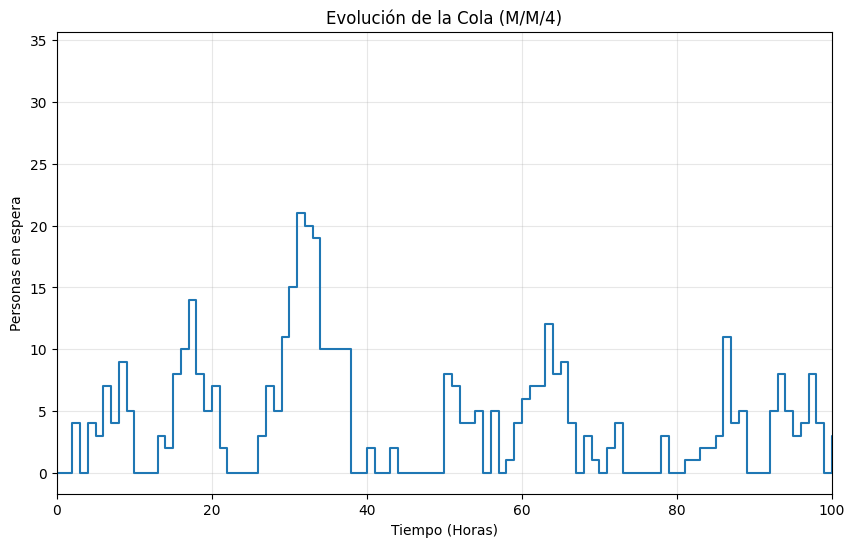

In [ ]:
plt.figure(figsize=(10, 6))
plt.step(clinica.monitor_tiempo, clinica.monitor_cola, where='post')
plt.title(f'Evolución de la Cola (M/M/{C})')
plt.xlabel('Tiempo (Horas)')
plt.ylabel('Personas en espera')
plt.grid(True, alpha=0.3)
# Limitamos la vista a las primeras 100 horas para que se vean los detalles
plt.xlim(0, min(100, TIEMPO))
plt.show()